# Imports & Config

In [1]:
# Notebook: ViT_CSE366.ipynb

import os, json, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # set True for a bit more speed (non-deterministic)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = (device.type == "cuda")
print("Device:", device)



DATA_ROOT = Path("/kaggle/input/a-dataset-of-citrus-fruit-images/A Dataset of Citrus Fruit Images/CitrusFruit/Augmentation")


train_dir = DATA_ROOT / "Train-A"
val_dir   = DATA_ROOT / "Val-A"
test_dir  = DATA_ROOT / "Test-A"

print("Train exists?", train_dir.exists())
print("Val exists?", val_dir.exists())
print("Test exists?", test_dir.exists())


IM_SIZE    = 224
BATCH_SIZE = 32
NUM_WORKERS= 2

# Fast schedule (same spirit as Stage C quick run)
PHASE1_EPOCHS = 1       # head-only warmup
PHASE2_EPOCHS = 2       # fine-tune
EARLY_STOP_PATIENCE = 2
LR_HEAD   = 3e-3
LR_FT     = 1e-4
WEIGHT_DECAY = 1e-4

VIT_BEST_PATH = "vit_best.pt"
RESULTS_JSON  = "vit_results.json"


Device: cpu
Train exists? True
Val exists? True
Test exists? True


# 1) Transforms, Datasets, DataLoaders

In [2]:
# ==========================================
# 1) Transforms, Datasets, DataLoaders
# ==========================================

train_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),   # ViT-friendly norm (also fine to use ImageNet stats)
])

eval_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

train_ds = datasets.ImageFolder(DATA_ROOT/"Train-A", transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_ROOT/"Val-A",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(DATA_ROOT/"Test-A",  transform=eval_tfms)

CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes: ['murcott', 'ponkan', 'tangerine', 'tankan']


# 2) Create ViT (torchvision ViT-B/16)

In [3]:
# ==========================================
# 2) Create ViT (torchvision ViT-B/16)
# ==========================================

import torchvision.models as tvm
from torchvision.models.vision_transformer import ViT_B_16_Weights

def create_vit_model(num_classes):
    # Pretrained ViT-B/16
    vit = tvm.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    in_feats = vit.heads.head.in_features
    vit.heads.head = nn.Linear(in_feats, num_classes)
    return vit.to(device), list(vit.heads.head.parameters())

vit, vit_head_params = create_vit_model(NUM_CLASSES)
print(vit.__class__.__name__, "ready.")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 192MB/s]  


VisionTransformer ready.


# 3) AMP helpers (PyTorch-1.x), train/eval

In [4]:
# ==========================================
# 3) AMP helpers (PyTorch-1.x), train/eval
# ==========================================

criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    all_t, all_p = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x); loss = criterion(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * y.size(0)
        correct    += (pred == y).sum().item()
        total      += y.size(0)
        all_t.extend(y.detach().cpu().tolist())
        all_p.extend(pred.detach().cpu().tolist())
    avg_loss = total_loss/total
    acc = correct/total
    report = classification_report(all_t, all_p, target_names=CLASSES, output_dict=True, zero_division=0)
    f1_macro = report["macro avg"]["f1-score"]
    return avg_loss, acc, f1_macro, np.array(all_t), np.array(all_p)

def set_trainable(module, flag=True):
    for p in module.parameters():
        p.requires_grad = flag

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x); loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * y.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.size(0)
    return total_loss/total, correct/total


# 4) Train ViT (Phase-1 head-only, Phase-2 fine-tune)

In [5]:
# =======================================================
# 4) Train ViT (Phase-1 head-only, Phase-2 fine-tune)¶
# =======================================================

# Phase 1: freeze backbone, train head
set_trainable(vit, False)
for p in vit_head_params: p.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vit.parameters()),
                              lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

best_f1 = -1.0
no_improve = 0

for ep in range(1, PHASE1_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(vit, train_loader, optimizer, scaler)
    val_loss, val_acc, val_f1, _, _ = evaluate(vit, val_loader)
    scheduler.step(val_f1)
    print(f"[ViT | Phase1 | Ep {ep}/{PHASE1_EPOCHS}] train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")
    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1; no_improve = 0
        torch.save({"model_state": vit.state_dict(), "arch": "vit_b_16", "val_f1": best_f1}, VIT_BEST_PATH)
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print("  Early stop (Phase1)."); break

# Phase 2: unfreeze & fine-tune
set_trainable(vit, True)
optimizer = torch.optim.AdamW(vit.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
no_improve = 0

for ep in range(1, PHASE2_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(vit, train_loader, optimizer, scaler)
    val_loss, val_acc, val_f1, _, _ = evaluate(vit, val_loader)
    scheduler.step(val_f1)
    print(f"[ViT | Phase2 | Ep {ep}/{PHASE2_EPOCHS}] train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")
    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1; no_improve = 0
        torch.save({"model_state": vit.state_dict(), "arch": "vit_b_16", "val_f1": best_f1}, VIT_BEST_PATH)
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print("  Early stop (Phase2)."); break


/tmp/ipykernel_10/1812121527.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_10/4044928794.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_10/4044928794.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[ViT | Phase1 | Ep 1/1] train_loss 0.2914 acc 0.9006 | val_loss 0.1940 acc 0.9545 f1 0.9529


/tmp/ipykernel_10/1812121527.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_10/4044928794.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_10/4044928794.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[ViT | Phase2 | Ep 1/2] train_loss 0.1259 acc 0.9586 | val_loss 0.1308 acc 0.9473 f1 0.9482


/tmp/ipykernel_10/4044928794.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_10/4044928794.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[ViT | Phase2 | Ep 2/2] train_loss 0.0246 acc 0.9914 | val_loss 0.0962 acc 0.9697 f1 0.9692


# 5) Final Test + Confusion Matrix + Save metrics

/tmp/ipykernel_10/4044928794.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


TEST (ViT) | loss 0.1333 | acc 0.9638 | macro-F1 0.9626

Classification Report (Test):

              precision    recall  f1-score   support

     murcott       0.96      0.93      0.95        28
      ponkan       0.92      1.00      0.96        33
   tangerine       0.97      0.95      0.96        40
      tankan       1.00      0.97      0.99        37

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.97      0.96      0.96       138



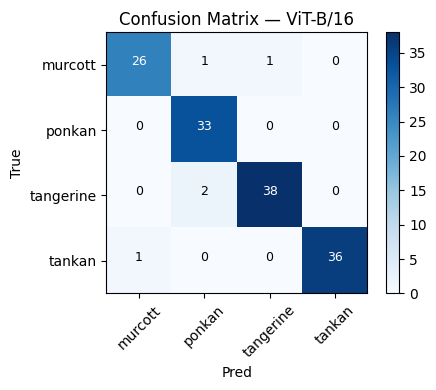

Saved: vit_results.json and vit_best.pt


In [ ]:
# ==================================================
# 5) Final Test + Confusion Matrix + Save metrics  (By Deb)
# ==================================================

ckpt = torch.load(VIT_BEST_PATH, map_location="cpu")
vit.load_state_dict(ckpt["model_state"]); vit.to(device)

test_loss, test_acc, test_f1, y_true, y_pred = evaluate(vit, test_loader)
print(f"TEST (ViT) | loss {test_loss:.4f} | acc {test_acc:.4f} | macro-F1 {test_f1:.4f}")

print("\nClassification Report (Test):\n")
print(classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix — ViT-B/16"); plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, CLASSES, rotation=45); plt.yticks(ticks, CLASSES)
th = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i,j] > th else "black", fontsize=9)
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout(); plt.show()

# Save a small results JSON
res = {
    "val_best_f1": ckpt.get("val_f1", None),
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
    "test_macro_f1": float(test_f1),
    "weights": VIT_BEST_PATH
}
with open(RESULTS_JSON, "w") as f:
    json.dump(res, f, indent=2)
print("Saved:", RESULTS_JSON, "and", VIT_BEST_PATH)


# 6) Append ViT row into Stage C table

In [8]:
# ==========================================
# 6) Append ViT row into Stage C table
# ==========================================
STAGEC_CSV = "/kaggle/input/combined-results-with-custom/combined_results_with_custom.csv"
df_prev = pd.read_csv(STAGEC_CSV)

vit_row = {
    "backbone": "vit_b_16",
    "val_best_f1": res["val_best_f1"],
    "test_loss": res["test_loss"],
    "test_acc":  res["test_acc"],
    "test_macro_f1": res["test_macro_f1"],
    "precision_macro": None,
    "recall_macro": None,
    "weights": VIT_BEST_PATH
}
df_all = pd.concat([df_prev, pd.DataFrame([vit_row])], ignore_index=True).sort_values("test_macro_f1", ascending=False)
display(df_all)
df_all.to_csv("combined_results_with_custom_and_vit.csv", index=False)
print("Saved: combined_results_with_custom_and_vit.csv")


/tmp/ipykernel_10/2891585276.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_prev, pd.DataFrame([vit_row])], ignore_index=True).sort_values("test_macro_f1", ascending=False)


,backbone,val_best_f1,test_loss,test_acc,test_macro_f1,precision_macro,recall_macro,weights
0,efficientnet_b0,0.963977,0.098645,0.971014,0.970384,0.969955,0.970996,tl_efficientnet_b0_best.pt
1,densenet121,0.970583,0.132183,0.971014,0.970378,0.972756,0.969643,tl_densenet121_best.pt
2,convnext_tiny,0.975736,0.066403,0.971014,0.970378,0.972756,0.969643,tl_convnext_tiny_best.pt
3,resnet34,0.958248,0.126828,0.963768,0.964518,0.965643,0.964746,tl_resnet34_best.pt
4,custom_cnn,0.922605,0.130963,0.963768,0.962815,NaN,NaN,custom_cnn_best.pt
5,vit_b_16,0.969184,0.133280,0.963768,0.962576,NaN,NaN,vit_best.pt


Saved: combined_results_with_custom_and_vit.csv
